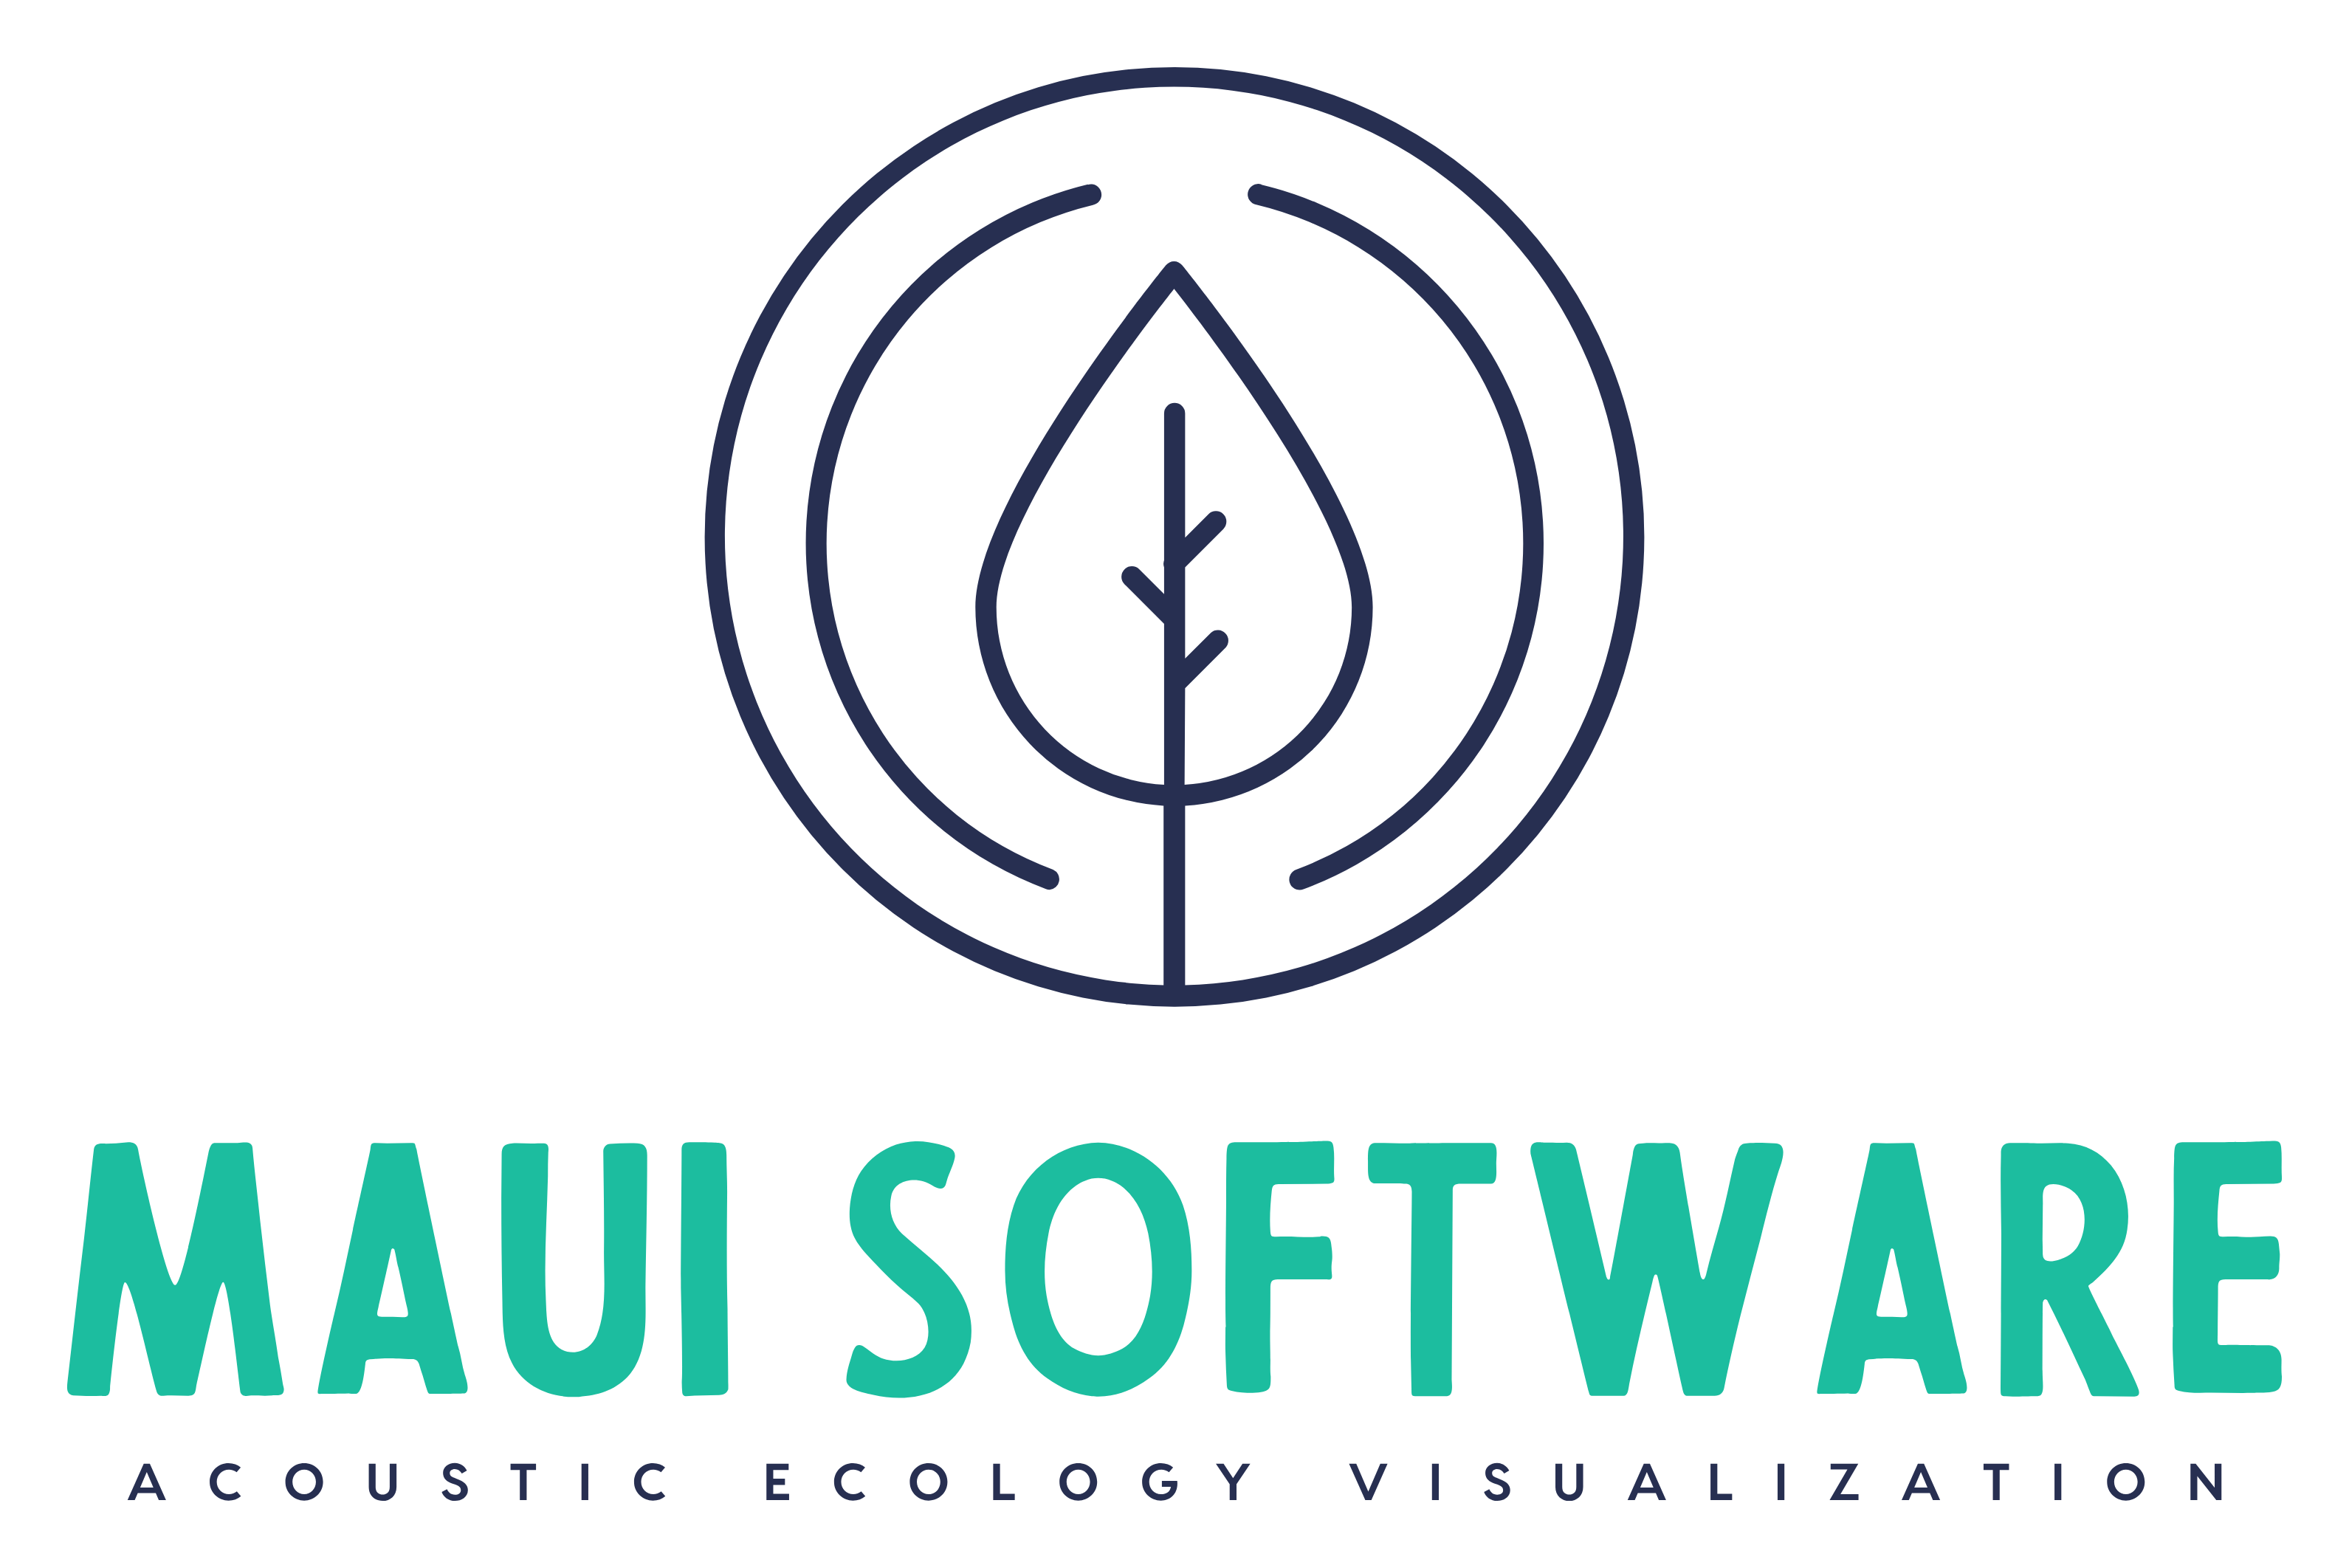

# Welcome to Maui!
## Examples series - Summary Visualizations

In this example, you'll see how ti create visualizations that summarize different aspects of the audios.

If you have any questions or encounter any issues, please let us know through the [project's GitHub discussions](https://github.com/maui-software/maui-software/discussions)!



# 1. Import Maui

## 1.1. Installation

Maui is available on PyPi and can be installed using pip with the following command. Maui has been specifically designed for use in coding interfaces like Colab and Jupyter Lab, leveraging the power of Plotly.



In [1]:
!pip install maui-software

We will also use ffmpeg package to convert .mp3 files to .wav

In [2]:
!pip install ffmpeg-python

## 1.2. Import

Once installed, it's time to import!

Maui consists of several submodules that need to be imported individually. In this tutorial, we illustrate the usage of the Samples, Visualizations, and Acoustic_indices modules.

The Samples module will be used to retrieve data from the [Xeno-Canto](https://xeno-canto.org/), the Acoustic_indices module will be used to obtain the acoustic indices, and the Visualizations module will be used to create visualizations from the data in the dataframe.

In [4]:
import os
import audioread
import ffmpeg
import pandas as pd
from scipy.io import wavfile
from tqdm import tqdm
import audioread

from maad import sound, util, features

from maui import samples, visualizations, acoustic_indices

# 2. Load dataset

The initial task is to load the data. In this example, we will use the Samples module to retrieve audio recordings from Brazil in the Xeno-Canto dataset. Maui relies on an abstraction of the Xeno-Canto API, which is simple to use.

The method downloads the data and returns a dataframe with all information necessary to create visualizations, such as the path to the audio file, the recording date and time, and other variables available in the Xeno-Canto repository.

We will use the following information from the recordings:

- **date**: the date of the recording (renamed to dt)
- **group**: the group to which the species belongs (birds, grasshoppers, bats)
- **stage**: the life stage of the animal (adult, juvenile, etc.)

We will also use the duration of the audios, which is calculated in this notebook.

A full description of each field of Xeno-Canto dataset is available at the [oficial website](https://xeno-canto.org/explore/api).

In [ ]:
params = {
    'cnt':'brazil'
}

df = samples.get_xc_data(q = params, extract_path="./xc_data")
unhashable_columns = df.columns[df.applymap(lambda x: isinstance(x, (list, dict))).any()]
df = df.drop(columns=unhashable_columns) # removing dictionary columns

df.rename(columns={'local_file_path': 'file_path', 'date': 'dt'}, inplace=True)

## 2.1. Get duration of the audios

We will use the duration of the audios for some visualizations, thus we need to calculate the duration of each audio of the dataset

In [6]:
# Define a function to calculate audio duration
def get_duration(file_path):
    with audioread.audio_open(file_path) as audio_file:
        return audio_file.duration

# Get the audio duration and add a progress bar to the process
tqdm.pandas(desc="Calculating audio duration")
df['duration'] = df['file_path'].progress_apply(get_duration)


Calculating audio duration: 100%|████████████████████████████████████████████| 500/500 [00:15<00:00, 31.82it/s]


In [7]:
df

,id,gen,sp,ssp,group,en,rec,cnt,loc,lat,...,playback-used,temp,regnr,auto,dvc,mic,smp,file_path,file_downloaded,duration
0,985165,Dendropsophus,microps,,frogs,Nova Friburgo Treefrog,Augusto Matheus dos Santos,Brazil,"Sitio Macuquinho, Salesópolis, São Paulo",-23.5849,...,no,,,no,Tascam Linear PCM Recorder,,44100,xc_data/XC985165-240907_2152-Dendropsophus-mic...,True,68.600000
1,984533,Scinax,imbegue,,frogs,,Kauê Werner,Brazil,"Itajaí, Itajaí, State of Santa Catarina",-26.9299,...,no,,,no,Zoom F3,Sennheiser ME66,96000,xc_data/XC984533-241005_038_Tr1_s_imbegue.wav,True,9.410323
2,984532,Leptodactylus,gracilis,,frogs,,Kauê Werner,Brazil,"Itajaí, Itajaí, State of Santa Catarina",-26.931,...,no,,,no,Zoom F3,Primo EM272 with parabolic reflector GM1,96000,xc_data/XC984532-250209_036_Tr1_l_gracilis.wav,True,12.145594
3,984531,Physalaemus,cuvieri,,frogs,Cuvier's Foam Froglet,Kauê Werner,Brazil,"Itajaí, Itajaí, State of Santa Catarina",-26.93,...,no,,,no,Zoom F3,Sennheiser ME66,96000,xc_data/XC984531-241005_017_Tr1_p_curvieri.wav,True,3.248177
4,984530,Physalaemus,nanus,,frogs,,Kauê Werner,Brazil,"Florianópolis, Florianópolis, Santa Catarina",-27.603,...,no,,,no,Sony D50,Internal,96000,xc_data/XC984530-241213_04_p_nanus.wav,True,33.520187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,167252,Crypturellus,cinereus,,birds,Cinereous Tinamou,GABRIEL LEITE,Brazil,"Machadinho d'Oeste, Rondônia",-8.9495,...,yes,,,no,,,48000,xc_data/XC167252-Crypturellus cinereus_Machadi...,True,38.000000
496,143922,Crypturellus,cinereus,,birds,Cinereous Tinamou,Rodrigo Dela Rosa,Brazil,"Senador Guiomard, State of Acre",-10.0725,...,yes,,,no,Marantz PMD661,Sennheiser ME67,48000,xc_data/XC143922-1189.mp3,True,91.600000
497,85038,Crypturellus,cinereus,,birds,Cinereous Tinamou,Jeremy Minns,Brazil,"Borba, Amazonas",-4.388175,...,unknown,,,no,,,44100,xc_data/CRYCIN21.mp3,True,23.700000
498,85037,Crypturellus,cinereus,,birds,Cinereous Tinamou,Jeremy Minns,Brazil,"Cristalino Jungle Lodge, MT",-9.5981,...,unknown,,,no,,,44100,xc_data/CRYCIN18.mp3,True,32.000000


## 2.2. Convert .mp3 files

The Xeno-Canto dataset is a collaborative project where people from around the world can submit audio recordings to the platform. Due to its collaborative nature, the audio files are not always in the same format, so conversion is necessary. We will convert the `.mp3` files in the dataset to `.wav` format, which offers higher audio quality.

In [8]:
def convert_mp3_to_wav(df, file_path_col, output_dir):
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)

  successful_conversions = 0
  failed_conversions = 0
  invalid_indices = []  # index of the lines with invalid conversion.

  # Create column to store the new file path of the audio converted to wav
  df['output_file_path'] = None

  print(df.shape[0])

  for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Converting files"):
      file_path = row[file_path_col]
      wav_file_path = None
      if file_path.endswith('.mp3'):
          try:
              # Defines the WAV file path
              base_name = os.path.basename(file_path)
              wav_file_name = os.path.splitext(base_name)[0] + '.wav'
              wav_file_path = os.path.join(output_dir, wav_file_name)
        
              # Convert MP3 to WAV
              ffmpeg\
              .input(file_path)\
              .output(wav_file_path)\
              .global_args('-hide_banner', '-loglevel', 'error')\
              .run(overwrite_output=True)

              
          except Exception:
              print('entrou')
              invalid_indices.append(index)
              failed_conversions += 1
              
      # Validate the conversion
      if wav_file_path is None: wav_file_path = file_path
      try:
        wavfile.read(wav_file_path)
        df.at[index, 'output_file_path'] = wav_file_path
        successful_conversions += 1
      except Exception:
        os.remove(wav_file_path)
        invalid_indices.append(index)
        failed_conversions += 1

  # Remove lines with invalid conversion
  df.drop(index=invalid_indices, inplace=True)

  print(f"Successfully converted audios: {successful_conversions}")

  return df

df = convert_mp3_to_wav(df, 'file_path', 'output_wav_files')


500


Converting files:   0%|                                                        | 1/500 [00:00<01:12,  6.92it/s]/tmp/ipykernel_1944089/1672554369.py:40: WavFileWarning: Chunk (non-data) not understood, skipping it.
  wavfile.read(wav_file_path)
Converting files:   3%|█▍                                                     | 13/500 [00:00<00:24, 19.76it/s]/tmp/ipykernel_1944089/1672554369.py:40: WavFileWarning: Chunk (non-data) not understood, skipping it.
  wavfile.read(wav_file_path)
Converting files:   5%|██▉                                                    | 27/500 [00:02<00:54,  8.64it/s]/tmp/ipykernel_1944089/1672554369.py:40: WavFileWarning: Chunk (non-data) not understood, skipping it.
  wavfile.read(wav_file_path)
Converting files:  12%|██████▌                                                | 60/500 [00:03<00:10, 41.01it/s]/tmp/ipykernel_1944089/1672554369.py:40: WavFileWarning: Chunk (non-data) not understood, skipping it.
  wavfile.read(wav_file_path)
Converting files:  13%|█

Successfully converted audios: 495


In [9]:
df.shape[0]

495

# 3. Acoustic Indices calculation

Acoustic indices will be used for some of the visualizations in this example. Maui does not implements acoustic indices directly, but implementes helper methods that make it easy the process of calculatino acoustic indices for a large dataset. There are three steps to calculate acoustic indices:

1. Define pre calculation methods
2. Define acoustic indices methods
3. Calculate the acoustic indices

We strongly recommend the use of calculation methods already available in the literature. In this example, we will use scikit-maad, a python framework that eficiently implements several acoustic indices.

## 3.1. Pre calculation method definition
Pre calculation methods are the data preparation step for calculation acoustic indices. it is a function that will be called at the beginning of the calculation, and will create columns on the original dataframe with the aditional data that will be necessary to calculate the desired acoustic indices.

The retun of the function should be a dictionary containning the name of the variable and the value that will be used by acoustic indices methods


In [10]:
def pre_calculation_method(s, fs):

    Sxx_power, tn, fn, ext = sound.spectrogram (s, fs)
    Sxx_noNoise= sound.median_equalizer(Sxx_power, display=False, extent=ext)
    Sxx_dB_noNoise = util.power2dB(Sxx_noNoise)

    Sxx, tn, fn, ext = sound.spectrogram(s, fs, mode='amplitude')

    pre_calc_vars = {'s':s, 'Sxx': Sxx, 'tn':tn , 'fn':fn , 'ext':ext, 'Sxx_dB_noNoise':Sxx_dB_noNoise }
    return pre_calc_vars

## 3.2. Acoustic indices methods definition

To calculate acoustic indices the user will need to define one function to each index that will be calculated. If the index needs some data that was calculated at the pra calculation step, the function that calculates the index should get as parameter **pre_calc_vars**, which is the dictionary returned by the pre calculation method.

Each method should return the value of the index, and they should be stored in a list to use at the next step. In this example, we created a list called **acoustic_indices_methods** with three acoustic indices that will be calculated.

In [11]:
def get_aci(pre_calc_vars):
    aci_xx, aci_per_bin, aci_sum  = features.acoustic_complexity_index(pre_calc_vars['Sxx'])
    indices = {'aci_xx': aci_xx, 'aci_per_bin':aci_per_bin , 'aci_sum':aci_sum}
    return indices

def get_temporal_entropy(pre_calc_vars):
    Ht = features.temporal_entropy(pre_calc_vars['s'])

    indices = {'Ht': Ht}
    return indices


def get_spectral_activity(pre_calc_vars):
    LFC, MFC, HFC = features.spectral_cover(pre_calc_vars['Sxx_dB_noNoise'], pre_calc_vars['fn'])

    indices = {'LFC': LFC, 'MFC':MFC , 'HFC':HFC}
    return indices

acoustic_indices_methods = [get_aci, get_temporal_entropy, get_spectral_activity]

## 3.3. Calculate acoustic indices

This is the moment when the acoustic indices will be calculated. We will use the methods defined at steps 1 and 2. The user can also decide to use paralel or sequential computing. The method require a temporary directory to store preliminar results, which will be accessed in case of failure at some point of the processing. This is necessary because acoustic indices calculation are often high demmand tasks.

In [12]:
temp_dir = os.path.abspath('.//temp_ac_files/')
df_valid = df[df['output_file_path'].notnull()]

df_indices = acoustic_indices.calculate_acoustic_indices(
                    df_init = df_valid,
                    file_path_col = 'output_file_path',
                    acoustic_indices_methods = acoustic_indices_methods,
                    pre_calculation_method = pre_calculation_method,
                    parallel=False,
                    chunk_size = 5,
                    temp_dir = temp_dir
        )


Calculating acoustic indices...
Preparing final dataframe and removing temporary files...
Fixing data types...


In [13]:
df_indices

,id,gen,sp,ssp,group,en,rec,cnt,loc,lat,...,file_downloaded,duration,output_file_path,aci_xx,aci_per_bin,aci_sum,Ht,LFC,MFC,HFC
0,985165,Dendropsophus,microps,NaN,frogs,Nova Friburgo Treefrog,Augusto Matheus dos Santos,Brazil,Sitio Macuquinho Salesópolis São Paulo,-23.584900,...,True,68.600000,output_wav_files/XC985165-240907_2152-Dendrops...,1.40752349e-04 9.46602818e-05 1.91598771e-04 ....,"[0.99496305, 0.68195801, 0.61248233, 0.6130832...",352.469317,0.794557,0.225207,0.365322,0.272690
1,984533,Scinax,imbegue,NaN,frogs,NaN,Kauê Werner,Brazil,Itajaí Itajaí State of Santa Catarina,-26.929900,...,True,9.410323,xc_data/XC984533-241005_038_Tr1_s_imbegue.wav,7.26753904e-05 1.47364968e-04 1.45731543e-04 ....,"[0.86899136, 0.86896404, 0.64088786, 0.5855097...",320.655536,0.895769,0.162460,0.262585,0.145461
2,984532,Leptodactylus,gracilis,NaN,frogs,NaN,Kauê Werner,Brazil,Itajaí Itajaí State of Santa Catarina,-26.931000,...,True,12.145594,xc_data/XC984532-250209_036_Tr1_l_gracilis.wav,1.72441831e-04 1.62584060e-04 1.46180913e-04 ....,"[0.83577421, 0.83602768, 0.65216896, 0.6192252...",311.448747,0.594822,0.163774,0.190409,0.143291
3,984531,Physalaemus,cuvieri,NaN,frogs,Cuvier's Foam Froglet,Kauê Werner,Brazil,Itajaí Itajaí State of Santa Catarina,-26.930000,...,True,3.248177,xc_data/XC984531-241005_017_Tr1_p_curvieri.wav,1.07511418e-05 4.63207924e-05 2.52941044e-05 ....,"[0.7308955, 0.72736663, 0.29740868, 0.29704309...",299.673067,0.806556,0.346217,0.290169,0.152745
4,984530,Physalaemus,nanus,NaN,frogs,NaN,Kauê Werner,Brazil,Florianópolis Florianópolis Santa Catarina,-27.603000,...,True,33.520187,xc_data/XC984530-241213_04_p_nanus.wav,1.00133886e-04 8.02622265e-05 1.04802343e-04 ....,"[0.88406418, 0.88352576, 0.68231253, 0.6248656...",304.888947,0.721355,0.190656,0.180658,0.131353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,167252,Crypturellus,cinereus,NaN,birds,Cinereous Tinamou,GABRIEL LEITE,Brazil,Machadinho d'Oeste Rondônia,-8.949500,...,True,38.000000,output_wav_files/XC167252-Crypturellus cinereu...,7.67440805e-08 1.82815823e-04 7.98542382e-04 ....,"[0.68334442, 0.54345493, 0.58646911, 0.5814091...",319.221817,0.729569,0.142675,0.167044,0.141616
491,143922,Crypturellus,cinereus,NaN,birds,Cinereous Tinamou,Rodrigo Dela Rosa,Brazil,Senador Guiomard State of Acre,-10.072500,...,True,91.600000,output_wav_files/XC143922-1189.wav,0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0....,"[0.69755249, 0.69068548, 0.45267473, 0.4683397...",298.965246,0.734271,0.169122,0.197779,0.156211
492,85038,Crypturellus,cinereus,NaN,birds,Cinereous Tinamou,Jeremy Minns,Brazil,Borba Amazonas,-4.388175,...,True,23.700000,output_wav_files/CRYCIN21.wav,8.42239234e-04 8.28494593e-05 7.70260758e-04 ....,"[0.92719682, 0.78218483, 0.54491291, 0.5678707...",327.812905,0.856120,0.169480,0.177306,0.230905
493,85037,Crypturellus,cinereus,NaN,birds,Cinereous Tinamou,Jeremy Minns,Brazil,Cristalino Jungle Lodge MT,-9.598100,...,True,32.000000,output_wav_files/CRYCIN18.wav,4.49439475e-04 4.22591724e-04 3.13453882e-04 ....,"[0.75711025, 0.41840236, 0.48398449, 0.6010370...",308.364912,0.678454,0.157817,0.211583,0.144809


# 4. Visualizations

Now that we have all the necessary data, it is time to create some visualizations!

In this example notebook, the goal is to create visualizations that summarize the data. To achieve this goal, we will create and discuss the following visualizations:

1. Radar plots
2. Histogram plots
3. Violin plots

The acoustic indices used in the visualizations are the following:

1. ACI_sum (Acoustic Complexity Index – sum)
- **Measures**: Variability in the soundscape (often bird calls).
- **Interpretation**: Higher values indicate more temporal variability (e.g., more biological activity or vocal diversity).
- **Use**: Commonly used to assess biodiversity in ecoacoustic studies.

2. Ht (Shannon Entropy of Entropy)
- **Measures**: Complexity or unpredictability of the sound signal over time.
- **Interpretation**: High values reflect more even and complex distributions of acoustic energy.
- **Use**: Helps in distinguishing between structured biological sounds and homogeneous noise.

3. LFC (Low-Frequency Content)
- **Measures**: Proportion of acoustic energy in low-frequency bands.
- **Interpretation**: High values may indicate presence of wind, traffic, or low-pitched animals.
- **Use**: Often used to detect anthropogenic noise or large species.

4. MFC (Mid-Frequency Content)
- **Measures**: Proportion of energy in the mid-frequency range.
- **Interpretation**: Typically captures bird songs and insect sounds.
- **Use**: Useful in biodiversity monitoring where mid-frequency biological signals dominate.

5. HFC (High-Frequency Content)
- **Measures**: Proportion of energy in high-frequency bands.
- **Interpretation**: High values may point to insect activity or electronic noise.
- **Use**: Assesses high-pitched biological or anthropogenic sounds.

## 4.1. Radar plot

The radar plot reveals significant differences in acoustic patterns between groups and stages. Birds generally show greater diversity in indices such as Ht, while land mammals stand out in LFC and aci_sum. The uneven distribution between groups in certain stages (such as juvenile and uncertain) also highlights variability and data limitations in some categories.


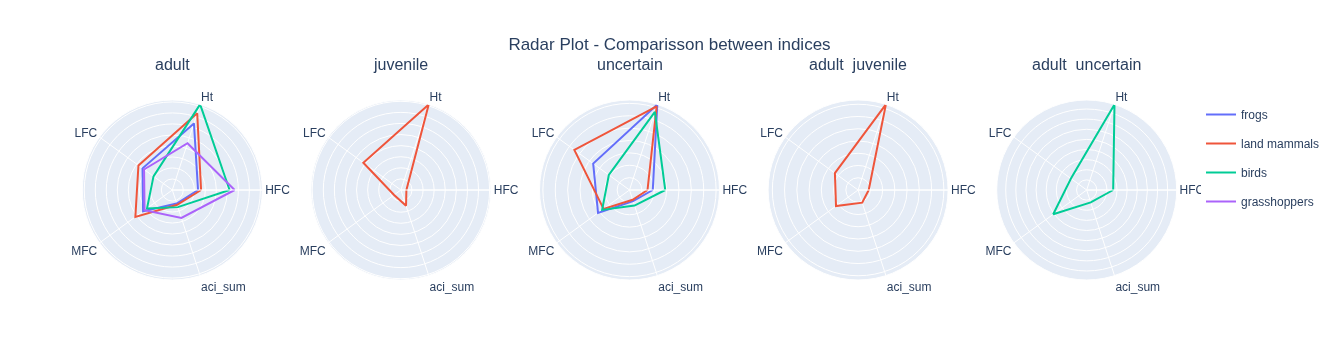

In [17]:
df_valid = df_indices.dropna(subset=['group', 'stage'])
fig = visualizations.indices_radar_plot(df_valid, indices=['aci_sum', 'Ht', 'LFC', 'MFC', 'HFC'], agg_type='mean', group_by=['stage', 'group'], max_cols=6)

## 4.2. Histogram plot

The histogram analysis indicates a biologically active soundscape characterized by moderate acoustic complexity (aci_sum), high entropy (Ht), and consistent mid-frequency content (MFC). Most recordings show high entropy values, suggesting a diverse and evenly distributed acoustic environment. The moderate values of aci_sum and MFC further support the presence of various sound-producing organisms, such as birds and insects, pointing to a healthy and dynamic natural or semi-natural habitat.

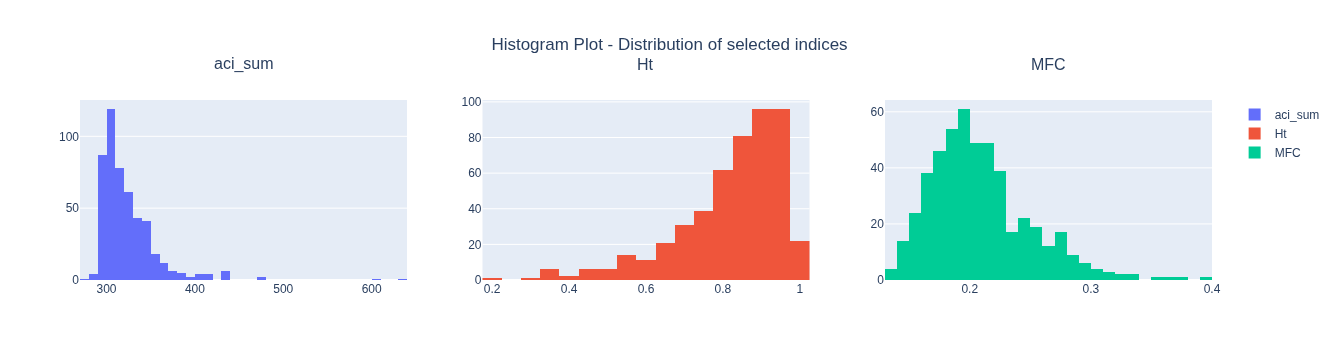

In [18]:
fig = visualizations.indices_histogram_plot(df_indices, indices=['aci_sum', 'Ht', 'MFC'], group_by=None, max_cols=3)

## 4.3. Violin plot

The violin plot reveals that the adult group exhibits the greatest variability and highest concentration of acoustic complexity (aci_sum), suggesting a wide range of vocal activity. The uncertain group shows a similar but slightly narrower distribution. In contrast, the juvenile and combined categories have limited representation and low variability, indicating fewer data points. Overall, the data suggest that adults are the primary contributors to acoustic complexity in the soundscape.

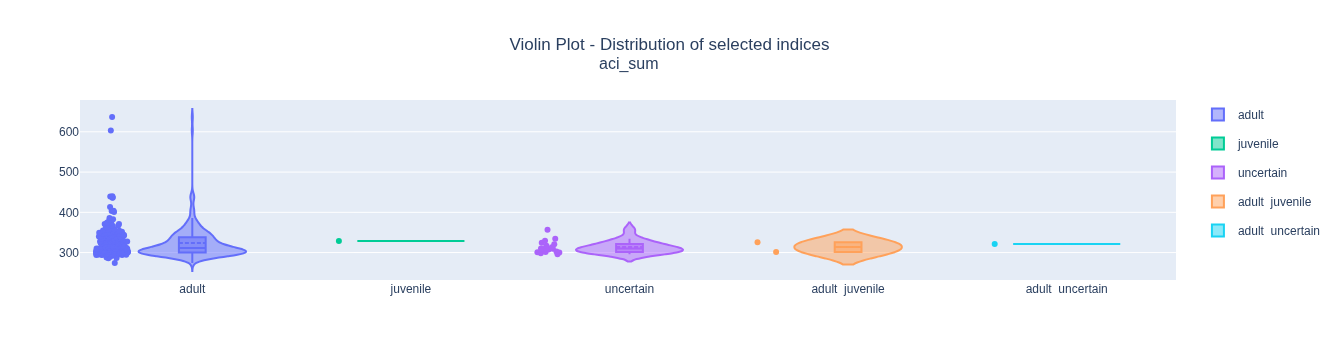

In [16]:
fig = visualizations.indices_violin_plot(df_indices, indices=['aci_sum'], group_by='stage')